In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from pandas_datareader import data as pdr

# Obtener datos del portafolio
def get_data(stocks, start, end):
    stockData = pdr.get_data_yahoo(stocks, start, end)
    stockData = stockData['Close']
    returns = stockData.pct_change()
    meanReturns = returns.mean()
    covMatrix = returns.cov()
    return meanReturns, covMatrix

#Definimos nuestro portafolio y el numero de datos historicos que queremos 
stocks = ['AAPL', 'T', 'AMZN']
endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days=300)

meanReturns, covMatrix = get_data(stocks, startDate, endDate)

#Generamos pesos aleatorios
weights = np.random.random(len(meanReturns))
weights /= np.sum(weights)

# Simulacion de MC
# numero de simulaciones
sims = 10000
#dias de la simulacion a futuro
T = 365 

meanM = np.full(shape=(T, len(weights)), fill_value=meanReturns)
#determinamos el "drift" de la simulacion
meanM = meanM.T

portfolio_sims = np.full(shape=(T, sims), fill_value=0.0)

#Valor inicial de portafolio 
initialPortfolio = 10000

for m in range(0, sims):
    #generacion de variables aleatorias normales
    Z = np.random.normal(size=(T, len(weights)))
    #Cholesky
    L = np.linalg.cholesky(covMatrix)
    #Retoronos diarios correlacionados de las acciones
    dailyReturns = meanM + np.inner(L, Z) 
    #vamos acumulando retornos a través deltiempo
    portfolio_sims[:,m] = np.cumprod(np.inner(weights, dailyReturns.T)+1)*initialPortfolio



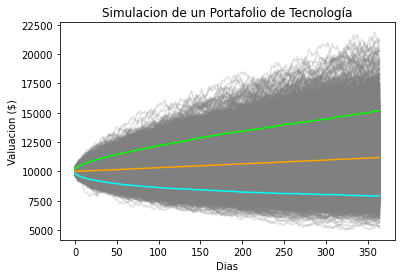

In [23]:
#Graficamos
fig,ax=plt.subplots()
ax.plot(portfolio_sims,color="grey", alpha=0.25)
plt.ylabel('Valuacion ($)')
plt.xlabel('Dias')
plt.title('Simulacion de un Portafolio de Tecnología')
ax.plot(np.arange(0,365),portfolio_sims.mean(axis=1), color="orange")
ax.plot(np.arange(0,365),np.quantile(portfolio_sims,axis=1, q=0.05), color="cyan")
ax.plot(np.arange(0,365),np.quantile(portfolio_sims,axis=1, q=0.95), color="lime")
#plt.savefig('sims.png', dpi=300, bbox_inches='tight')

In [24]:
#portfolio_sims.mean(axis=1)
#np.quantile(portfolio_sims,axis=1, q=0.05)
print(portfolio_sims.max())
portfolio_sims.min()

21860.750372530856


5005.8137847948055

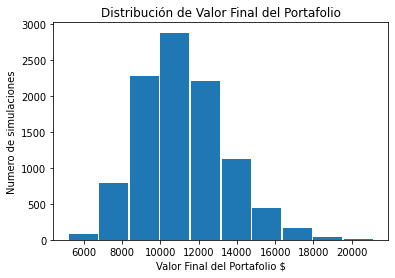

In [25]:
#Histograma de últimos precios
plt.hist(portfolio_sims[T-1,:], rwidth=0.95)
plt.xlabel('Valor Final del Portafolio $')
plt.ylabel('Numero de simulaciones')
plt.title('Distribución de Valor Final del Portafolio')
plt.savefig('sims.png', dpi=300, bbox_inches='tight')

In [26]:
#Todos los ultimos precios simulados
print("Count:", len(portfolio_sims[T-1,:]))
print("Media:", np.mean(portfolio_sims[T-1,:]))
print("Varianza:", np.var(portfolio_sims[T-1,:]))
print("Stdev:", np.std(portfolio_sims[T-1,:]))
print("Max:", np.max(portfolio_sims[T-1,:]))
print("Min:", np.min(portfolio_sims[T-1,:]))

minimo=np.min(portfolio_sims[T-1,:])
maximo=np.max(portfolio_sims[T-1,:])

maxgain= maximo-initialPortfolio
maxloss= minimo-initialPortfolio

mean=np.mean(portfolio_sims[T-1,:])
expected = mean-initialPortfolio

print("Ganancia Maxima:", maxgain)
print("Perdida Maxima:", maxloss)
print("perdida/ganancia esperada: ", expected)

Count: 10000
Media: 11177.745899270285
Varianza: 4916255.786220287
Stdev: 2217.263129675927
Max: 21154.125397612952
Min: 5171.94866153456
Ganancia Maxima: 11154.125397612952
Perdida Maxima: -4828.05133846544
perdida/ganancia esperada:  1177.745899270285


In [27]:
#Pandas decribe
valores=pd.DataFrame(portfolio_sims[T-1,:], columns=['valor_final']);
valores.describe()

,valor_final
count,10000.000000
mean,11177.745899
std,2217.374001
min,5171.948662
25%,9586.848102
50%,10992.310676
75%,12530.697613
max,21154.125398


In [28]:
valores2=pd.DataFrame(portfolio_sims[T-1,:], columns=['valor_final']);
valores3=valores2>17500


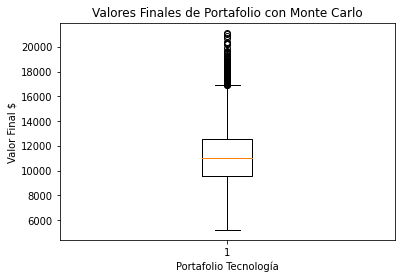

In [29]:
plt.boxplot(portfolio_sims[T-1,:])
plt.title('Valores Finales de Portafolio con Monte Carlo')
plt.xlabel('Portafolio Tecnología')
plt.ylabel('Valor Final $')
plt.savefig('sims.png', dpi=300, bbox_inches='tight')

In [30]:
#df=pd.DataFrame(portfolio_sims)
#df.apply(np.log).diff().plot()
#plt.show()

In [31]:
#Calculo de Probas
#Probabilidad de acumular un valor final o menos
#veamos con 10,500
valores2=valores[valores["valor_final"]<10500]
len(valores2)/len(valores)

0.4124

In [32]:
#Veamos cuantiles de los ultimos valores
cuantil_025=np.quantile(portfolio_sims[T-1,:], 0.975)
cuantil_10=np.quantile(portfolio_sims[T-1,:], 0.9)
cuantil_05=np.quantile(portfolio_sims[T-1,:], 0.95)
cuantil_01=np.quantile(portfolio_sims[T-1,:], 0.99)
print(cuantil_025)
print(cuantil_10)
print(cuantil_05)
print(cuantil_01)

16084.598972211637
14087.672608860168
15168.96013012238
17163.708889301553


In [33]:
#percentiles
per5=np.percentile(valores["valor_final"],5)
perdida = per5-initialPortfolio
print(per5)
print(perdida)

per95=np.percentile(valores["valor_final"],95)
ganancia = per95-initialPortfolio
print(per95)
print(ganancia)

7923.869891046201
-2076.130108953799
15168.96013012238
5168.960130122379


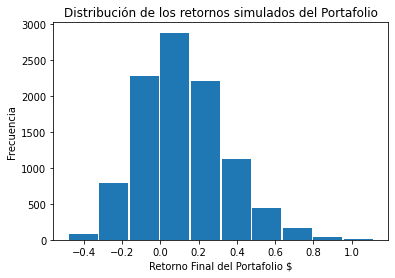

In [34]:
#grafiquemos ganancias
import scipy as sp
from scipy.stats import lognorm
#returns como %
returns=(valores["valor_final"]-initialPortfolio)/initialPortfolio
plt.hist(returns,rwidth=0.95)
plt.xlabel('Retorno Final del Portafolio $')
plt.ylabel('Frecuencia')
plt.title('Distribución de los retornos simulados del Portafolio')
plt.savefig('sims.png', dpi=300, bbox_inches='tight')

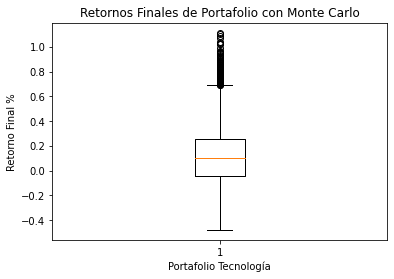

In [35]:
plt.boxplot(returns)
plt.title('Retornos Finales de Portafolio con Monte Carlo')
plt.xlabel('Portafolio Tecnología')
plt.ylabel('Retorno Final %')
plt.savefig('sims.png', dpi=300, bbox_inches='tight')

In [77]:
returns.describe()

count    10000.000000
mean         0.091476
std          0.247658
min         -0.544228
25%         -0.086589
50%          0.063150
75%          0.239459
max          1.285799
Name: valor_final, dtype: float64